<img src='../OUTILS/bandeau_MF.png' align='right' width='100%'/>

<div class="alert alert-info alert-success">
<h3>Elaboration de la RGB Cloud Phase - FCI /MTG </h3></div>

## <a id='TOC-TOP'></a>Contenus

<div class="alert alert-block alert-warning">
    
<b>PREREQUIS </b>
    
Ce Notebook ne nécessite pas de prérequis

</div>
<hr>

<div class="alert alert-info" role="alert">

## <a id='section1'></a>1.Tout d'abord, il faut procéder à l'importation des librairies nécessaires.

</div>

In [ ]:
from PIL import Image
from IPython.display import display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy
import os

### Données d'entrée : fichier multicanaux mtg

In [ ]:
input = '../DATA/Multic2km_mtgi1_20231122_1400.nc'

In [ ]:
input

### Définition du dossier de sortie :

In [ ]:
pwd

In [ ]:
download_dir = os.path.join(os.getcwd(), "../output")
os.makedirs(download_dir, exist_ok=True)

In [ ]:
output = '../output'

In [ ]:
output

In [ ]:
!gdalinfo $input

<div class="alert alert-info" role="alert">

## <a id='section2'></a>2.Extraction des données dans le NetCDF
[Back to top](#TOC-TOP)

</div>


Pour rappel, la recette de la RGB cloud phase est la suivante :

<img src='../OUTILS/cloudphase_tableau.png' align='right' width='100%'/>

Red: NIR1.61, range 0 to 50 %, Gamma = 1

Green: NIR2.25, Range 0 to 50 %, Gamma = 1

Blue: VIS0.64, range 0 to 100 %, Gamma = 1

Extraction des données des trois longueurs d'ondes nécessaires aux calculs des différences :

In [ ]:
!pwd

In [ ]:
!gdal_translate NETCDF:"$input":IR_016 {output}/016.tif

In [ ]:
!gdal_translate NETCDF:"$input":IR_016 {output}/016.tif
!gdal_translate NETCDF:"$input":IR_022 {output}/022.tif
!gdal_translate NETCDF:"$input":VIS006 {output}/006.tif

Extraction des données IR_016 pour la bande rouge.
Les valeurs 0 et 50 % 


In [ ]:
!gdal_translate -ot byte -scale 0 5000 0 255 NETCDF:"$input":IR_016 {output}/016_scale.tif

Extraction des données IR_022 pour la bande verte.
Les valeurs 0 et 50 % 
Extraction des données IR VIS006 pour la bande bleue.
Les valeurs 0 et 100 % 



In [ ]:
!gdal_translate -ot byte -scale 0 5000 0 255 NETCDF:"$input":IR_022 {output}/022_scale.tif
!gdal_translate -ot byte -scale 0 10000 0 255 NETCDF:"$input":VIS006 {output}/006_scale.tif

### Calcul de la correction gamma avec gdal_calc.py :

Pour rappel la formule de la correction gamme est :

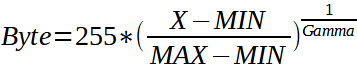


(Note : imagemagick permet de faire une correction gamma mais n'est pas compatible avec Windows)

La première étape consiste à extraire les valeurs min et max de l'image.

In [ ]:
#cd ../output

In [ ]:
file_in = '../output/016_scale.tif'
imgpil = Image.open(file_in)  
img = np.array(imgpil)
max = np.max(img)
min = np.min(img)

Ensuite on calcule et on applique la correction gamma pour une valeur de 1 :

In [ ]:
#gamma= 1
#meilleur résultat avec 
gamma= 1.7

In [ ]:
!gdal_calc.py --quiet --NoDataValue 0 --overwrite -A {file_in} --calc="numpy.maximum(A*0.,{max}*((A-{min}.)/({max}-{min}))**(1/{gamma}))" --outfile {output}/016_scale_gamma.tif

In [ ]:
file_in = '../output/022_scale.tif'
imgpil = Image.open(file_in)  
img = np.array(imgpil)
max = np.max(img)
min = np.min(img)

In [ ]:
gamma= 1

In [ ]:
#gamma= 1
#meilleur résultat avec 
gamma= 1.6

In [ ]:
!gdal_calc.py --quiet --NoDataValue 0 --overwrite -A {file_in} --calc="numpy.maximum(A*0.,{max}*((A-{min}.)/({max}-{min}))**(1/{gamma}))" --outfile {output}/022_scale_gamma.tif

In [ ]:
file_in = '../output/006_scale.tif'
imgpil = Image.open(file_in)  
img = np.array(imgpil)
max = np.max(img)
min = np.min(img)

In [ ]:
gamma= 1

In [ ]:
!gdal_calc.py --quiet --NoDataValue 0 --overwrite -A {file_in} --calc="numpy.maximum(A*0.,{max}*((A-{min}.)/({max}-{min}))**(1/{gamma}))" --outfile {output}/006_scale_gamma.tif

<div class="alert alert-info" role="alert">

## <a id='section3'></a>3.Fabrication de la RGB
[Back to top](#TOC-TOP)

</div>


In [ ]:
!gdal_merge.py -separate {output}/016_scale_gamma.tif {output}/022_scale_gamma.tif {output}/006_scale_gamma.tif -o {output}/RGB_cloudphase.tif

### Création et affichage d'une image redimmensionnée

In [ ]:
!convert -resize 500x500 {output}/RGB_cloudphase.tif {output}/RGB_cloudphase_min.jpg

### Visualisation du résultat

In [ ]:
im = Image.open(output + '/RGB_cloudphase_min.jpg', 'r')
display(im)

### Définition de la zone du zoom

In [ ]:
N=40
S=15
O=-23
E=8

In [ ]:
!gdalwarp -t_srs "EPSG:4326" -te -23 15 8 40 -overwrite {output}/RGB_cloudphase.tif {output}/RGB_cloudphase_zoom.tif

### Création et affichage d'une image zoomée redimmensionnée

In [ ]:
!convert -resize 500x500 {output}/RGB_cloudphase_zoom.tif {output}/RGB_cloudphase_zoom_min.jpg

In [ ]:
im2 = Image.open(output + '/RGB_cloudphase_zoom_min.jpg', 'r')
display(im2)